In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

from PIL import Image
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from sklearn.model_selection import train_test_split

In [2]:
INITIAL_LR = 0.01
MODEL_NAME = "big_dataset"

dir = '../data/big_dataset'
# categories = sorted(os.listdir(dir))
categories = ['cloudy', 'foggy', 'rain', 'snow', 'sunny']
nb_classes = len(categories)

X = []
Y = []

image_w = 64
image_h = 64

for idx, f in enumerate(categories):
    print(idx, f)
    label = [0 for _ in range(nb_classes)]
    label[idx] = 1
    image_dir = dir + "/" + f
    files = glob.glob(image_dir + "/*.jpg")

    for i, fname in enumerate(files):
        if i % 10000 == 0:
            print(i)

        img = Image.open(fname)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)
        X.append(data)
        Y.append(idx)

X = np.array(X) / 255.0
Y = np.array(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y)

y_train = to_categorical(y_train, len(categories))
y_test = to_categorical(y_test, len(categories))

print('X_train shape: ', x_train.shape[0])
print('Y_train shape: ', y_train.shape)

0 cloudy
0
10000
20000
30000
40000
1 foggy
0
2 rain
0
3 snow
0
4 sunny
0
10000
20000
30000
40000
50000
60000
70000
X_train shape:  89355
Y_train shape:  (89355, 5)


In [3]:
# applying transformation to image
train_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.5,
    height_shift_range=0.5,
    brightness_range=[0.25, 1.5],
    horizontal_flip=True, )

# test_gen = ImageDataGenerator()
train_gen.fit(x_train)
test_set = train_gen.flow(x_test, y_test, batch_size=256)

model = Sequential()

# Block 1
model.add(Conv2D(32, kernel_size=3, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), padding='same', input_shape=(image_w, image_h, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Block 2
model.add(Conv2D(64, kernel_size=3, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(2, 2))

# Block 3
model.add(Conv2D(128, kernel_size=3, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Block 4
model.add(Conv2D(256, kernel_size=3, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(2, 2))

# Block 5
model.add(Conv2D(512, kernel_size=3, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Block 6
model.add(Conv2D(1024, kernel_size=3, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(2, 2))

model.add(Flatten())

# Dense 1
model.add(Dense(1400, kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Dense 2
model.add(Dense(len(categories), kernel_regularizer=l2(0.0005), activation='softmax'))

# Visualize Model
model.summary()


def lr_scheduler(epoch):
    if epoch < 20:
        return INITIAL_LR
    elif epoch < 40:
        return INITIAL_LR / 20
    elif epoch < 50:
        return INITIAL_LR / 40
    elif epoch < 60:
        return INITIAL_LR / 80
    elif epoch < 70:
        return INITIAL_LR / 160
    elif epoch < 80:
        return INITIAL_LR / 320
    elif epoch < 90:
        return INITIAL_LR / 640
    else:
        return INITIAL_LR / 1280


model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(INITIAL_LR),
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=100,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[LearningRateScheduler(lr_scheduler)],
    shuffle=True
)

model.save('../models/' + MODEL_NAME)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

2793/2793 [==============================] - 539s 193ms/step - loss: 0.3989 - accuracy: 0.8705 - val_loss: 3.5447 - val_accuracy: 0.5769
Epoch 31/100
2793/2793 [==============================] - 528s 189ms/step - loss: 0.4020 - accuracy: 0.8711 - val_loss: 0.4577 - val_accuracy: 0.8505
Epoch 32/100
2793/2793 [==============================] - 528s 189ms/step - loss: 0.3898 - accuracy: 0.8702 - val_loss: 23.4134 - val_accuracy: 0.3889
Epoch 33/100
2793/2793 [==============================] - 529s 189ms/step - loss: 0.3857 - accuracy: 0.8705 - val_loss: 0.7588 - val_accuracy: 0.7773
Epoch 34/100
2793/2793 [==============================] - 529s 189ms/step - loss: 0.3809 - accuracy: 0.8731 - val_loss: 34.8572 - val_accuracy: 0.0026
Epoch 35/100
2793/2793 [==============================] - 529s 189ms/step - loss: 0.3941 - accuracy: 0.8704 - val_loss: 20.8969 - val_accuracy: 0.0107
Epoch 36/100
2793/2793 [==============================] - 529s 189ms/step - loss: 0.3821 - accuracy: 0.8735 - 

2793/2793 [==============================] - 527s 189ms/step - loss: 0.3216 - accuracy: 0.8876 - val_loss: 0.3424 - val_accuracy: 0.8789
Epoch 85/100
2793/2793 [==============================] - 527s 189ms/step - loss: 0.3252 - accuracy: 0.8862 - val_loss: 0.3283 - val_accuracy: 0.8881
Epoch 86/100
2793/2793 [==============================] - 527s 189ms/step - loss: 0.3201 - accuracy: 0.8880 - val_loss: 0.4220 - val_accuracy: 0.8460
Epoch 87/100
2793/2793 [==============================] - 527s 189ms/step - loss: 0.3240 - accuracy: 0.8878 - val_loss: 0.4416 - val_accuracy: 0.8330
Epoch 88/100
2793/2793 [==============================] - 527s 189ms/step - loss: 0.3216 - accuracy: 0.8878 - val_loss: 0.3283 - val_accuracy: 0.8888
Epoch 89/100
2793/2793 [==============================] - 527s 189ms/step - loss: 0.3206 - accuracy: 0.8889 - val_loss: 0.3228 - val_accuracy: 0.8891
Epoch 90/100
2793/2793 [==============================] - 527s 189ms/step - loss: 0.3162 - accuracy: 0.8898 - val

Test loss: 0.32756686210632324 / Test accuracy: 88.71281743049622


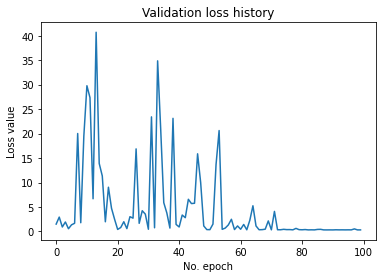

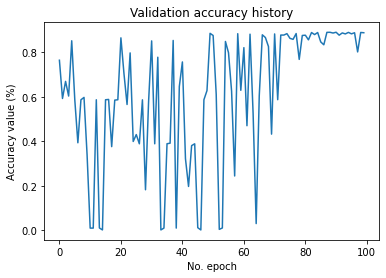

<Figure size 432x288 with 0 Axes>

In [4]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1] * 100}')
# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()
plt.savefig('../models/' + MODEL_NAME + '/val_loss.jpg')
# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()
plt.savefig('../models/' + MODEL_NAME + '/val_acc.jpg')